In [230]:
import numpy as np
import pandas as pd
import json
import plotly.express as px

from epilepsypcm.utils.outcome_params import node_location, early_propogation, irritative_zone

from epilepsypcm.utils.make_df import make_df, get_df_list, concat_dfs
from epilepsypcm.models.base_models import *
from sklearn.metrics import auc


all_positive_patients = pd.read_csv("df_final.csv", sep = ',', index_col = 0).reset_index(drop = True)
print(all_positive_patients["outcome"].value_counts())


0.0    259
1.0     56
Name: outcome, dtype: int64


In [197]:
all_positive_patients.head()

,Channels,outcome,IZ,EP,SigResp,SigStim,N1RespAvg,N1RespSDV,N2RespAvg,N2RespSDV,...,N1StimSDV,N2StimAvg,N2StimSDV,P2StimAvg,P2StimSDV,patient,InDegree,OutDegree,EV,Closeness
0,LA1_LA2,1.0,0.0,0.0,0.000000,0.064516,0.000000,0.000000,0.000000,0.000000,...,2.011706,3.724259,3.460362,2.796966,3.000218,PY21N008,0.000000,0.071429,4.993936e-14,0.000000
1,LA9_LA10,0.0,1.0,0.0,0.000000,0.193548,1.808045,1.676081,2.493333,2.341456,...,9.957544,5.060794,6.246739,4.478926,6.889325,PY21N008,0.000000,0.214286,4.993936e-14,0.000000
2,LAH1_LAH2,1.0,1.0,0.0,0.064516,0.193548,7.116911,19.154270,4.252294,5.048311,...,14.745868,3.809967,3.367630,1.821021,1.867067,PY21N008,0.071429,0.214286,7.960633e-04,0.174603
3,LAH8_LAH9,0.0,0.0,0.0,0.290323,0.096774,4.306443,3.856300,4.059026,4.970039,...,2.173960,1.695722,1.598789,1.574253,2.044144,PY21N008,0.321429,0.107143,1.590588e-01,0.480159
4,LPH1_LPH2,0.0,1.0,0.0,0.096774,0.258065,5.792531,15.863221,3.143365,3.299196,...,7.764073,3.585250,3.693649,3.242192,3.639533,PY21N008,0.107143,0.285714,4.743272e-03,0.218807


In [198]:
all_positive_patients["patient"].value_counts()

PY21N004    46
PY21N002    39
PY21N008    31
PY18N015    24
PY19N026    23
PY18N013    20
PY21N006    20
PY18N016    19
PY20N001    17
PY19N012    17
PY18N002    16
PY19N023    14
PY16N008     9
PY19N009     8
PY17N005     5
PY17N008     4
PY16N013     3
Name: patient, dtype: int64

In [199]:
#scaling original data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

all_positive_patients_norm = all_positive_patients

patient_list = all_positive_patients["patient"]
all_positive_patients_norm = all_positive_patients_norm.drop(['Channels', "patient"], axis = 1)
all_positive_patients_norm =  pd.DataFrame(scaler.fit_transform(all_positive_patients_norm.to_numpy()))
all_positive_patients_norm["patient"] = patient_list

In [200]:
patient_df = all_positive_patients_norm.groupby(by = ["patient"]).mean()
patient_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
patient,,,,,,,,,,,,,,,,,,,,,
PY16N008,0.333333,0.333333,0.00,0.195602,0.200617,0.164193,0.104672,0.109099,0.080189,0.214729,...,0.167691,0.101105,0.115796,0.061533,0.168954,0.072589,0.240741,0.240741,0.405874,0.322986
PY16N013,0.000000,0.333333,0.00,0.270833,0.277778,0.360883,0.189456,0.266252,0.249138,0.087595,...,0.368573,0.195130,0.340871,0.235600,0.059010,0.018300,0.666667,0.666667,0.666667,0.666667
PY17N005,0.200000,0.000000,0.00,0.487500,0.500000,0.277625,0.161090,0.219309,0.208649,0.358159,...,0.283540,0.152627,0.273639,0.141840,0.292992,0.099758,0.500000,0.500000,0.601284,0.564286
PY17N008,0.000000,0.750000,0.75,0.130580,0.117188,0.046634,0.020204,0.051603,0.048049,0.078397,...,0.045184,0.018858,0.029611,0.032682,0.045048,0.013629,0.500000,0.500000,0.500000,0.500000
PY18N002,0.312500,0.187500,0.25,0.069643,0.087484,0.081150,0.086667,0.084885,0.095804,0.078026,...,0.084327,0.083009,0.085656,0.086904,0.052315,0.033880,0.104167,0.104167,0.168034,0.121466


In [201]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
components = pca.fit_transform(patient_df)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

patient_df = patient_df.reset_index()

In [202]:
pca_df = pd.DataFrame(components)
pca_df.columns = ["PC1", "PC2", "PC3"]

print(pca.explained_variance_)

[0.13102119 0.09089295 0.02426413]


In [203]:
fig = px.scatter_3d(
    pca_df,
    x = "PC1",
    y = "PC2",
    z = "PC3",
    #labels=labels,
    color=patient_df["patient"],
    title = "PCA by CCEP data"
)

fig.show()

## clustering by patient characteristics

In [277]:
# outcome, 0 = no surgery, 1-4 = engel score. then using only 1 and 2 for PCA
# electrode_type, 0 = subdural electrodes, 1 = subdural electrodes + depth, 
                 #2 = SEEG, 3 = Strip + grid + depth
# age, 0 = 0s, 1 = 10s, 2 = 20s, 3 = 30s, 4 = 40s, 5 = 50s, 6 = 60s
# gender, 0 = Male, 1 = Female
# Mri, no changes, still categorical

patient_chars = pd.read_csv("patient_characteristics.csv", sep = ',').reset_index(drop = True)

#taking only engel 1 + 2
#patient_chars = patient_chars[(patient_chars["Outcome"] == 1) | (patient_chars["Outcome"] == 2)].reset_index()
patient_chars = patient_chars[(patient_chars["Outcome"] == 1)].reset_index()


patient_chars.head()

,index,patient,Gender,Age,MRI,Electrode Type,Outcome
0,0,PY16N006,1,3,Left middle temporal gyrus lesion- path + low ...,0,1
1,1,PY16N008,1,4,Previous right anterior temporal lobectomy wit...,0,1
2,3,PY16N013,0,1,Focal cortical dysplasia in the left anterior ...,0,1
3,6,PY17N008,1,1,Right middle frontal gyrus dysplasia,1,1
4,8,PY17N014,0,3,Gliosis in posterior lateral superior left par...,0,1


In [278]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

patient_chars_norm = patient_chars

patient_list = patient_chars_norm["patient"]
patient_chars_norm = patient_chars_norm.drop(["MRI", "patient"], axis = 1)
patient_chars_norm =  pd.DataFrame(scaler.fit_transform(patient_chars_norm.to_numpy()))
patient_chars_norm["patient"] = patient_list

patient_chars_norm.set_index("patient", inplace = True)

In [279]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components = 4)
components = pca.fit_transform(patient_chars_norm)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

patient_chars_norm = patient_chars_norm.reset_index()

In [280]:
pca_df = pd.DataFrame(components)
pca_df.columns = ["PC1", "PC2", "PC3", "PC4"]

print(pca.explained_variance_)

[0.27588734 0.18901459 0.0985218  0.01817665]


In [281]:
fig = px.scatter_3d(
    pca_df,
    x = "PC1",
    y = "PC2",
    z = "PC3",
    #labels=labels,
    color=patient_chars_norm["patient"],
    title = "PCA by patient characteristic : "
)

fig.show()

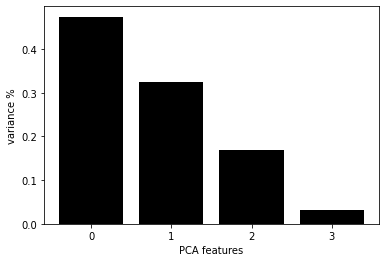

In [282]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(components)

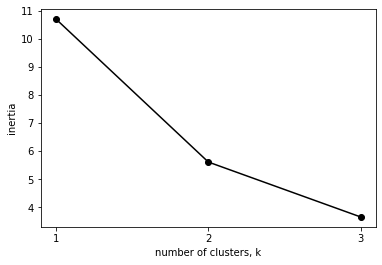

In [283]:
# visualizing clusters from PCA by patient characteristic via kmeans

from sklearn.cluster import KMeans

ks = range(1, 4)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [285]:
cluster_map = pd.DataFrame()
cluster_map['patient'] = patient_chars_norm.patient
cluster_map['cluster'] = model.labels_

patient_chars_clusters = patient_chars.merge(cluster_map, on = "patient")
patient_chars_clusters.sort_values(by = "cluster")

,index,patient,Gender,Age,MRI,Electrode Type,Outcome,cluster
16,38,PY21N004,0,2,Previous left hippocampal LiTT,3,1,0
14,30,PY20N001,0,5,Non-lesional,2,1,0
12,27,PY19N023,0,3,Right parietal encephalomalacia,2,1,0
11,22,PY19N012,0,4,Periventricular bilateral nodular heterotopia ...,2,1,0
18,41,PY21N008,0,2,Non-lesional,2,1,0
0,0,PY16N006,1,3,Left middle temporal gyrus lesion- path + low ...,0,1,1
17,39,PY21N006,1,4,Focal left fronto-parietal operculum dysplasia,2,1,1
15,37,PY21N002,1,4,Prior left frontal resection,2,1,1
13,29,PY19N026,1,3,Right mesial temporal sclerosis,2,1,1
10,21,PY19N009,1,5,Right mesial temporal sclerosis,2,1,1


## clustering with CCEP data + patient characteristics



In [315]:
all_positive_patients = pd.read_csv("df_final.csv", sep = ',', index_col = 0).reset_index(drop = True)
patient_chars = pd.read_csv("patient_characteristics.csv", sep = ',').reset_index(drop = True)

mri_df = patient_chars_clusters[["patient","MRI", "Age", "Gender", "Outcome", "Electrode Type"]]

combined_df = all_positive_patients.merge(patient_chars, on = "patient")

In [301]:
combined_df["Outcome"].value_counts()

1    275
2     40
Name: Outcome, dtype: int64

In [302]:
#scaling original data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

combined_df_norm = combined_df

patient_list = combined_df["patient"]

combined_df_norm = combined_df_norm.drop(['Channels', "patient", "MRI"], axis = 1)
col_names = combined_df_norm.columns
combined_df_norm =  pd.DataFrame(scaler.fit_transform(combined_df_norm.to_numpy()))

combined_df_norm["patient"] = patient_list

combined_patient_df = combined_df_norm.groupby(by = ["patient"]).mean()
combined_patient_df.columns = col_names
combined_patient_df.head()

,outcome,IZ,EP,SigResp,SigStim,N1RespAvg,N1RespSDV,N2RespAvg,N2RespSDV,P2RespAvg,P2RespSDV,N1StimAvg,N1StimSDV,N2StimAvg,N2StimSDV,P2StimAvg,P2StimSDV,InDegree,OutDegree,EV,Closeness,Gender,Age,Electrode Type,Outcome
patient,,,,,,,,,,,,,,,,,,,,,,,,,
PY16N008,0.333333,0.333333,0.00,0.195602,0.200617,0.164193,0.104672,0.109099,0.080189,0.214729,0.084016,0.167691,0.101105,0.115796,0.061533,0.168954,0.072589,0.240741,0.240741,0.405874,0.322986,1.0,0.6,0.000000,0.0
PY16N013,0.000000,0.333333,0.00,0.270833,0.277778,0.360883,0.189456,0.266252,0.249138,0.087595,0.023845,0.368573,0.195130,0.340871,0.235600,0.059010,0.018300,0.666667,0.666667,0.666667,0.666667,0.0,0.0,0.000000,0.0
PY17N005,0.200000,0.000000,0.00,0.487500,0.500000,0.277625,0.161090,0.219309,0.208649,0.358159,0.113957,0.283540,0.152627,0.273639,0.141840,0.292992,0.099758,0.500000,0.500000,0.601284,0.564286,1.0,0.4,0.000000,1.0
PY17N008,0.000000,0.750000,0.75,0.130580,0.117188,0.046634,0.020204,0.051603,0.048049,0.078397,0.027655,0.045184,0.018858,0.029611,0.032682,0.045048,0.013629,0.500000,0.500000,0.500000,0.500000,1.0,0.0,0.333333,0.0
PY18N002,0.312500,0.187500,0.25,0.069643,0.087484,0.081150,0.086667,0.084885,0.095804,0.078026,0.040817,0.084327,0.083009,0.085656,0.086904,0.052315,0.033880,0.104167,0.104167,0.168034,0.121466,0.0,1.0,0.666667,1.0


In [303]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
components = pca.fit_transform(combined_patient_df)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

combined_patient_df = combined_patient_df.reset_index()

In [304]:
pca_df = pd.DataFrame(components)
pca_df.columns = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"]

print(pca.explained_variance_)

[0.32241674 0.16302545 0.14525747 0.09479655 0.0631005  0.03922855
 0.01809023 0.00724112 0.00556498 0.00376508]


In [305]:
fig = px.scatter_3d(
    pca_df,
    x = "PC1",
    y = "PC2",
    z = "PC3",
    #labels=labels,
    color = combined_patient_df["patient"],
    title = "PCA by CCEP AND patient characteristics : "
)

fig.show()

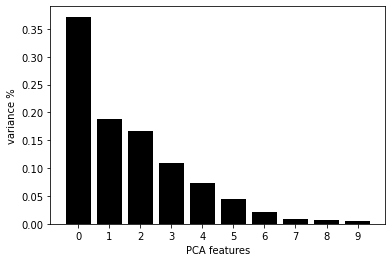

In [306]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(components)

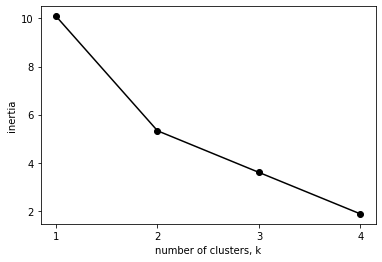

In [307]:
# visualizing clusters from PCA by patient characteristic via kmeans

from sklearn.cluster import KMeans

ks = range(1, 5)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [314]:
cluster_map = pd.DataFrame()
cluster_map['patient'] = patient_df.patient
cluster_map['cluster'] = model.labels_

combined_df_clusters = combined_patient_df.merge(cluster_map, on = "patient")
combined_df_clusters.sort_values(by = "cluster", inplace = True)

combined_df_clusters = combined_df_clusters.merge(mri_df, on = "patient")

(17, 27)


(14, 32)

In [312]:
combined_df_clusters[["cluster", "patient", "Electrode Type_y", "MRI", "Age_y", "Gender_y"]]


,cluster,patient,Electrode Type_y,MRI,Age_y,Gender_y
0,0,PY16N008,0,Previous right anterior temporal lobectomy wit...,4,1
1,0,PY21N002,2,Prior left frontal resection,4,1
2,0,PY19N026,2,Right mesial temporal sclerosis,3,1
3,0,PY21N006,2,Focal left fronto-parietal operculum dysplasia,4,1
4,0,PY18N015,2,Right subfrontal epydymal cyst,3,1
5,0,PY19N009,2,Right mesial temporal sclerosis,5,1
6,0,PY17N008,1,Right middle frontal gyrus dysplasia,1,1
7,0,PY18N013,2,Previous left temporal resection,2,1
8,1,PY19N012,2,Periventricular bilateral nodular heterotopia ...,4,0
9,1,PY19N023,2,Right parietal encephalomalacia,3,0
